In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
import pandas.io.sql as pdsql
import collections
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs, rdBase
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from sklearn.model_selection import StratifiedKFold
import operator
import math
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors
import time
rdDepictor.SetPreferCoordGen(True)
import rdkit
%pylab inline
print(rdkit.__version__)

Populating the interactive namespace from numpy and matplotlib
2020.03.2


In [12]:
data=pd.read_csv('data_including_ch24.csv',sep='\t')
ms = [Chem.MolFromSmiles(x) for x in data.smiles]
fps_data = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, nBits=2048) for x in data.smiles]

In [144]:
y=np.asarray(data.active.tolist(),dtype="float")

In [5]:
len(fps_data)

535

In [6]:
from rdkit.SimDivFilters import rdSimDivPickers
lp = rdSimDivPickers.LeaderPicker()

In [138]:
thresh = 0.65 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(fps_data,len(fps_data),thresh)
print(len(picks))

44


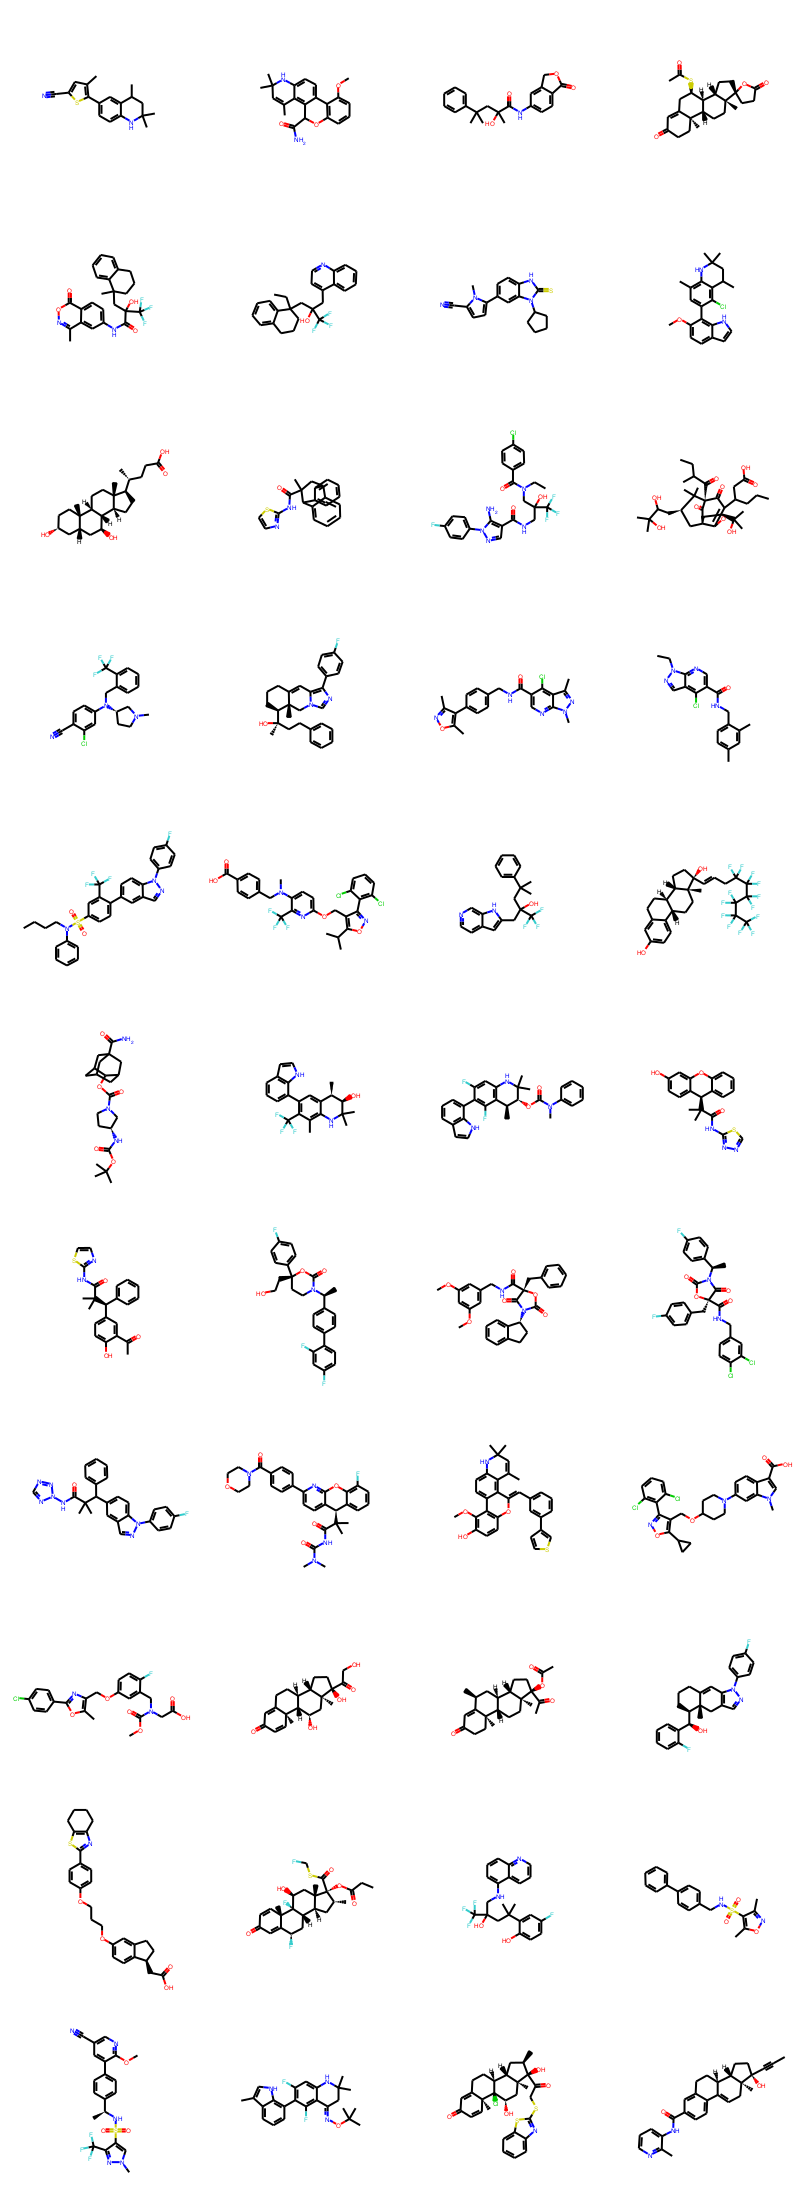

In [149]:
Draw.MolsToGridImage([ms[x] for x in picks[:44]],molsPerRow=4)

In [125]:
pickfps = [fps_data[x] for x in picks]
nearest = []
simhist = []
for i,fpi in enumerate(pickfps):
    tfps = pickfps[:]
    del tfps[i]
    sims = DataStructs.BulkTanimotoSimilarity(fpi,tfps)
    nearest.append(max(sims))
    simhist.extend(sims)
sorted(nearest,reverse=True)[:10]

[0.34782608695652173,
 0.34782608695652173,
 0.34615384615384615,
 0.34615384615384615,
 0.34523809523809523,
 0.34523809523809523,
 0.34523809523809523,
 0.34523809523809523,
 0.3448275862068966,
 0.3448275862068966]

Text(0.5, 0, 'similarity')

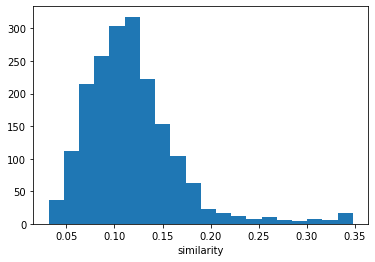

In [126]:
hist(simhist,bins=20)
xlabel('similarity')

In [127]:
from collections import defaultdict
import numpy as np
def assignPointsToClusters(picks,fps):
    clusters = defaultdict(list)
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    return clusters

Text(0.5, 0, 'cluster size')

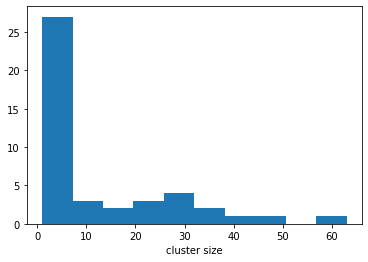

In [128]:
clusters = assignPointsToClusters(picks,fps_data)
hist([len(clusters[x]) for x in clusters])
xlabel('cluster size')

Text(0.5, 0, 'cluster size')

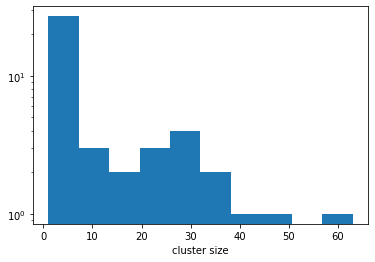

In [129]:
hist([len(clusters[x]) for x in clusters],log=True)
xlabel('cluster size')

In [135]:
len(clusters)

44

In [160]:
cluster50 = [x for x in clusters if len(clusters[x])>50]
len(cluster50)

1

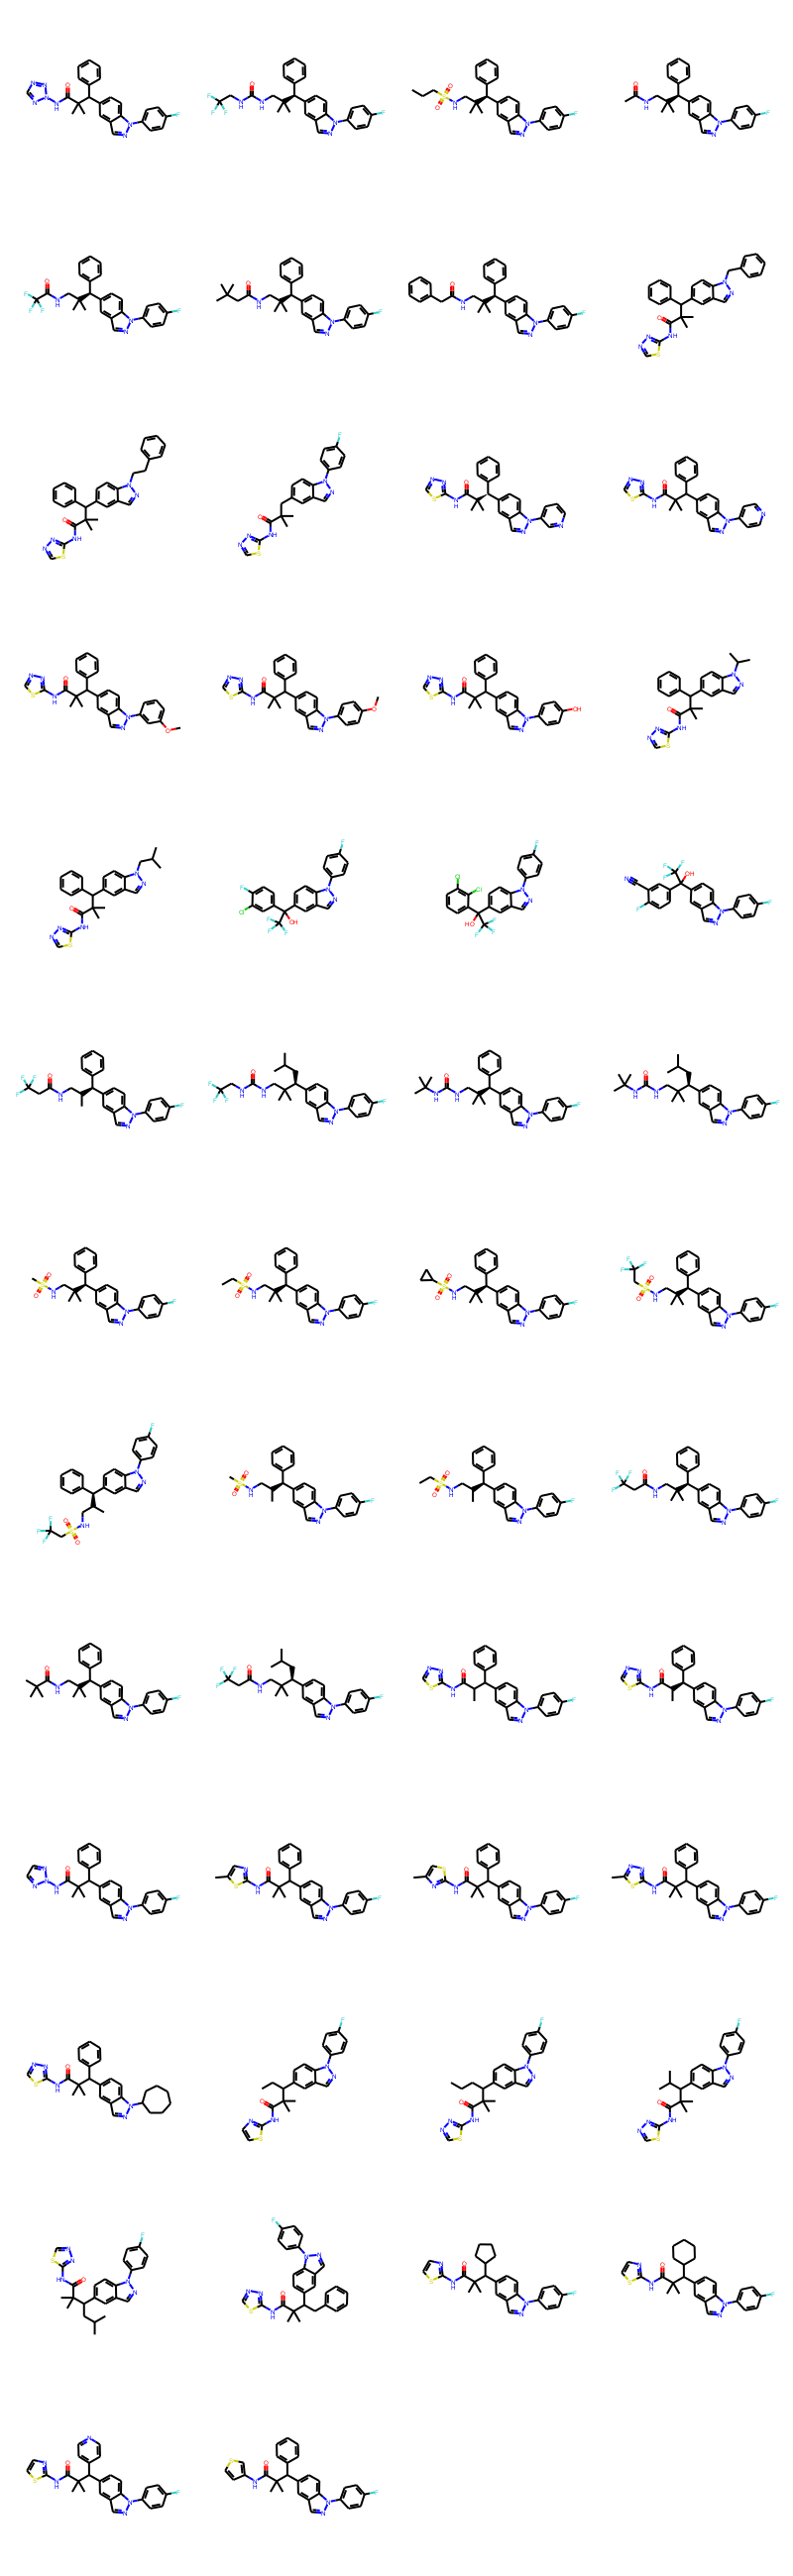

In [162]:
Draw.MolsToGridImage([ms[x] for x in clusters[cluster50[0]]],molsPerRow=4)

In [208]:
mols50 = [ms[x] for x in clusters[cluster50[0]]]

In [213]:
from rdkit.Chem import rdFMCS
mcs50 = rdFMCS.FindMCS(mols50)
print(f"MCS1 contains {mcs50.numAtoms} atoms and {mcs50.numBonds} bonds.")
print("MCS SMARTS string:", mcs50.smartsString)

MCS1 contains 15 atoms and 16 bonds.
MCS SMARTS string: [#6]-,:[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#6]:[#7]:[#7]:2-[#6]:,-[#6])-,:[#6]


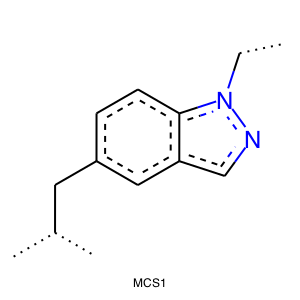

In [214]:
m50 = Chem.MolFromSmarts(mcs50.smartsString)
Draw.MolToImage(m50, legend="MCS1")

In [215]:
Chem.MolToSmiles(m50)

'C:CN1:N:C:C2:C:C(CC(C)C):C:C:C:2:1'

In [178]:
len(clusters[cluster50[0]])

63

In [163]:
a = [y[x] for x in clusters[cluster50[0]]]

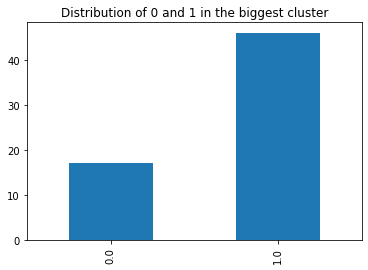

In [173]:
import pandas
from collections import Counter
letter_counts = Counter(a)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar', title = 'Distribution of 0 and 1 in the biggest cluster', legend = False)

In [179]:
cluster40 = [x for x in clusters if len(clusters[x])>40]
len(cluster40)

3

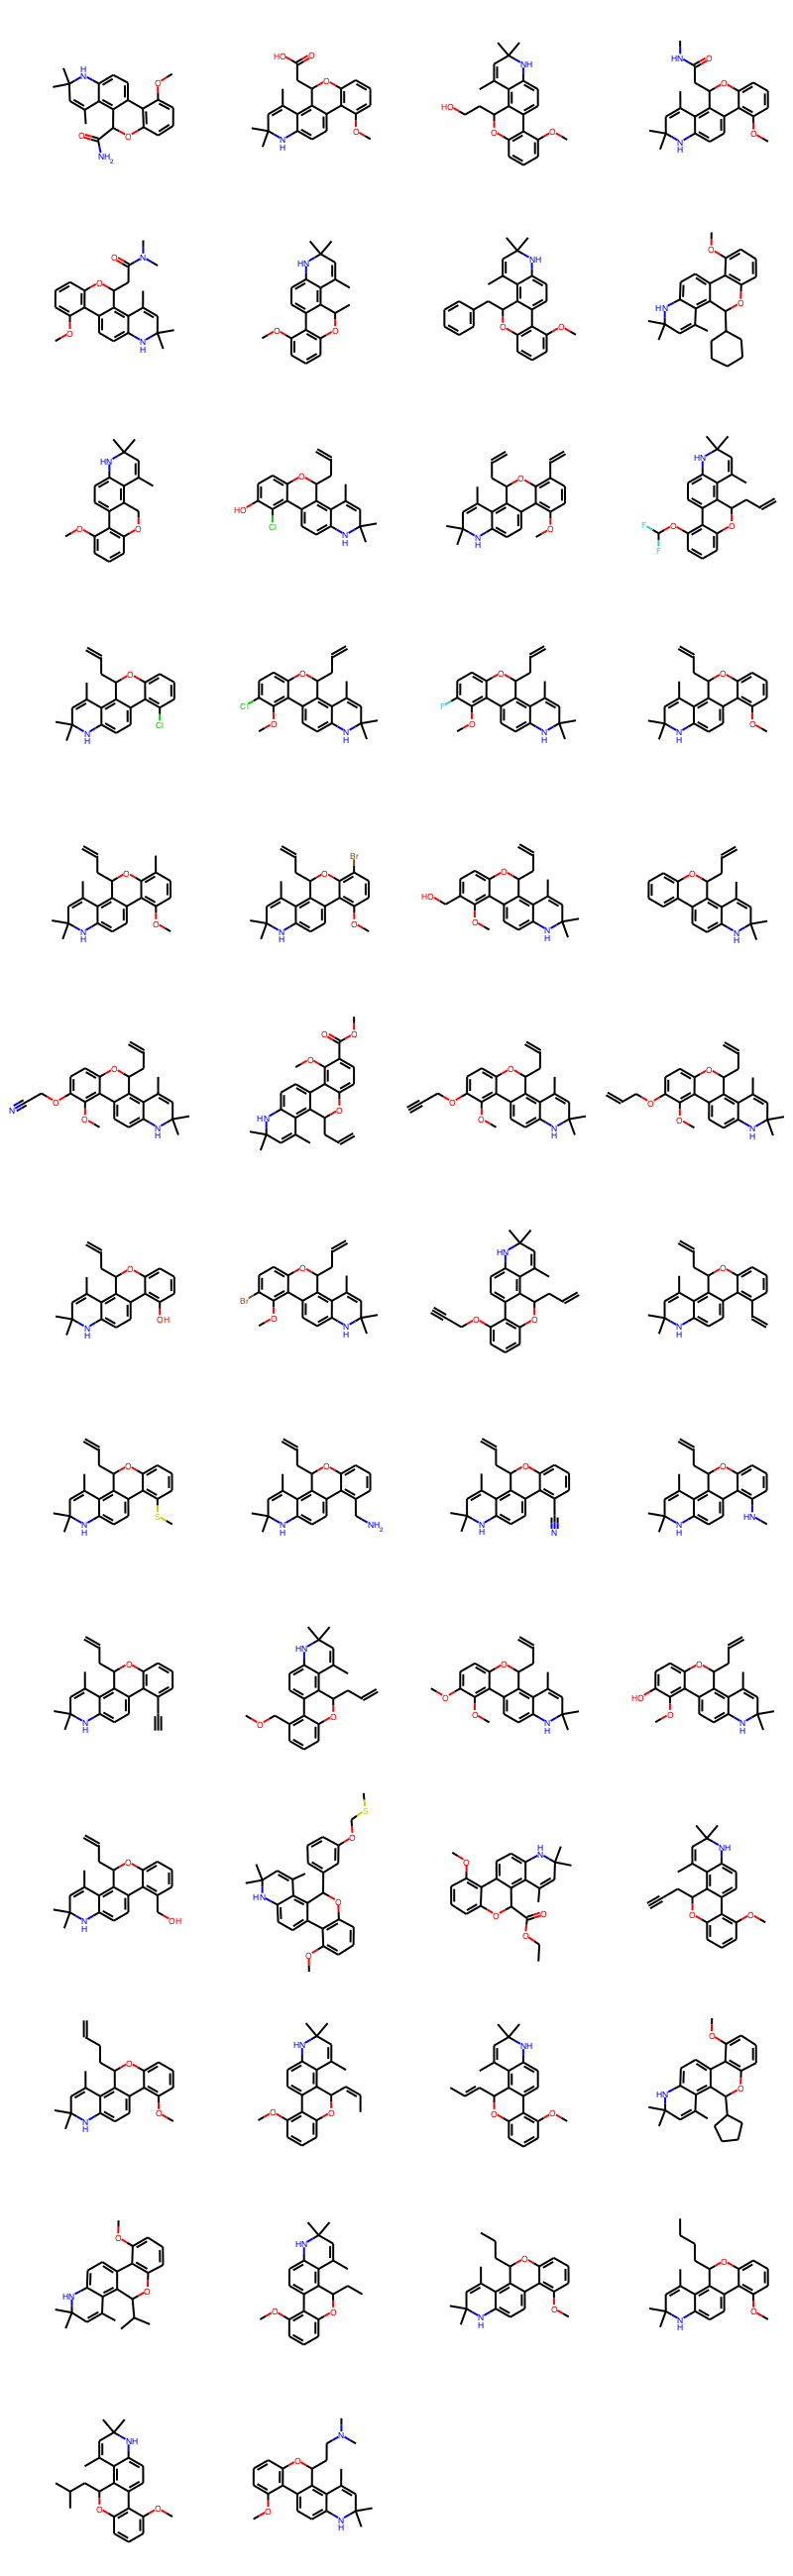

In [182]:
Draw.MolsToGridImage([ms[x] for x in clusters[cluster40[0]]],molsPerRow=4)

In [207]:
mols = [ms[x] for x in clusters[cluster40[0]]]

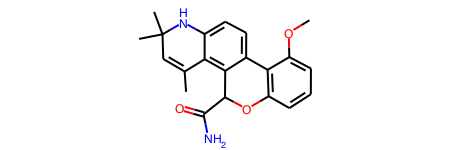

In [199]:
 mols[0]

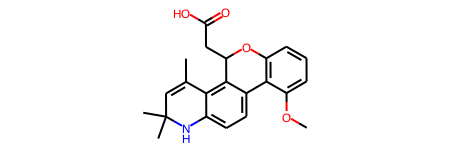

In [200]:
mols[1]

In [209]:
from rdkit.Chem import rdFMCS
mcs40 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs40.numAtoms} atoms and {mcs40.numBonds} bonds.")
print("MCS SMARTS string:", mcs40.smartsString)

MCS1 contains 21 atoms and 24 bonds.
MCS SMARTS string: [#6]1:[#6]:[#6]:[#6]:[#6]2:[#6]:1-[#6]1:[#6]:[#6]:[#6]3:[#6](:[#6]:1-[#6]-[#8]-2)-[#6](-[#6])=[#6]-[#6](-[#7]-3)(-[#6])-[#6]


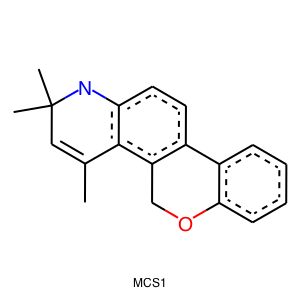

In [212]:
m40 = Chem.MolFromSmarts(mcs40.smartsString)
Draw.MolToImage(m40, legend="MCS1")

In [216]:
Chem.MolToSmiles(m40)

'CC1=CC(C)(C)NC2:C:C:C3:C(:C:21)COC1:C:C:C:C:C:13'

In [183]:
len(clusters[cluster40[0]])

50

In [189]:
[y[x] for x in clusters[cluster40[0]]]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

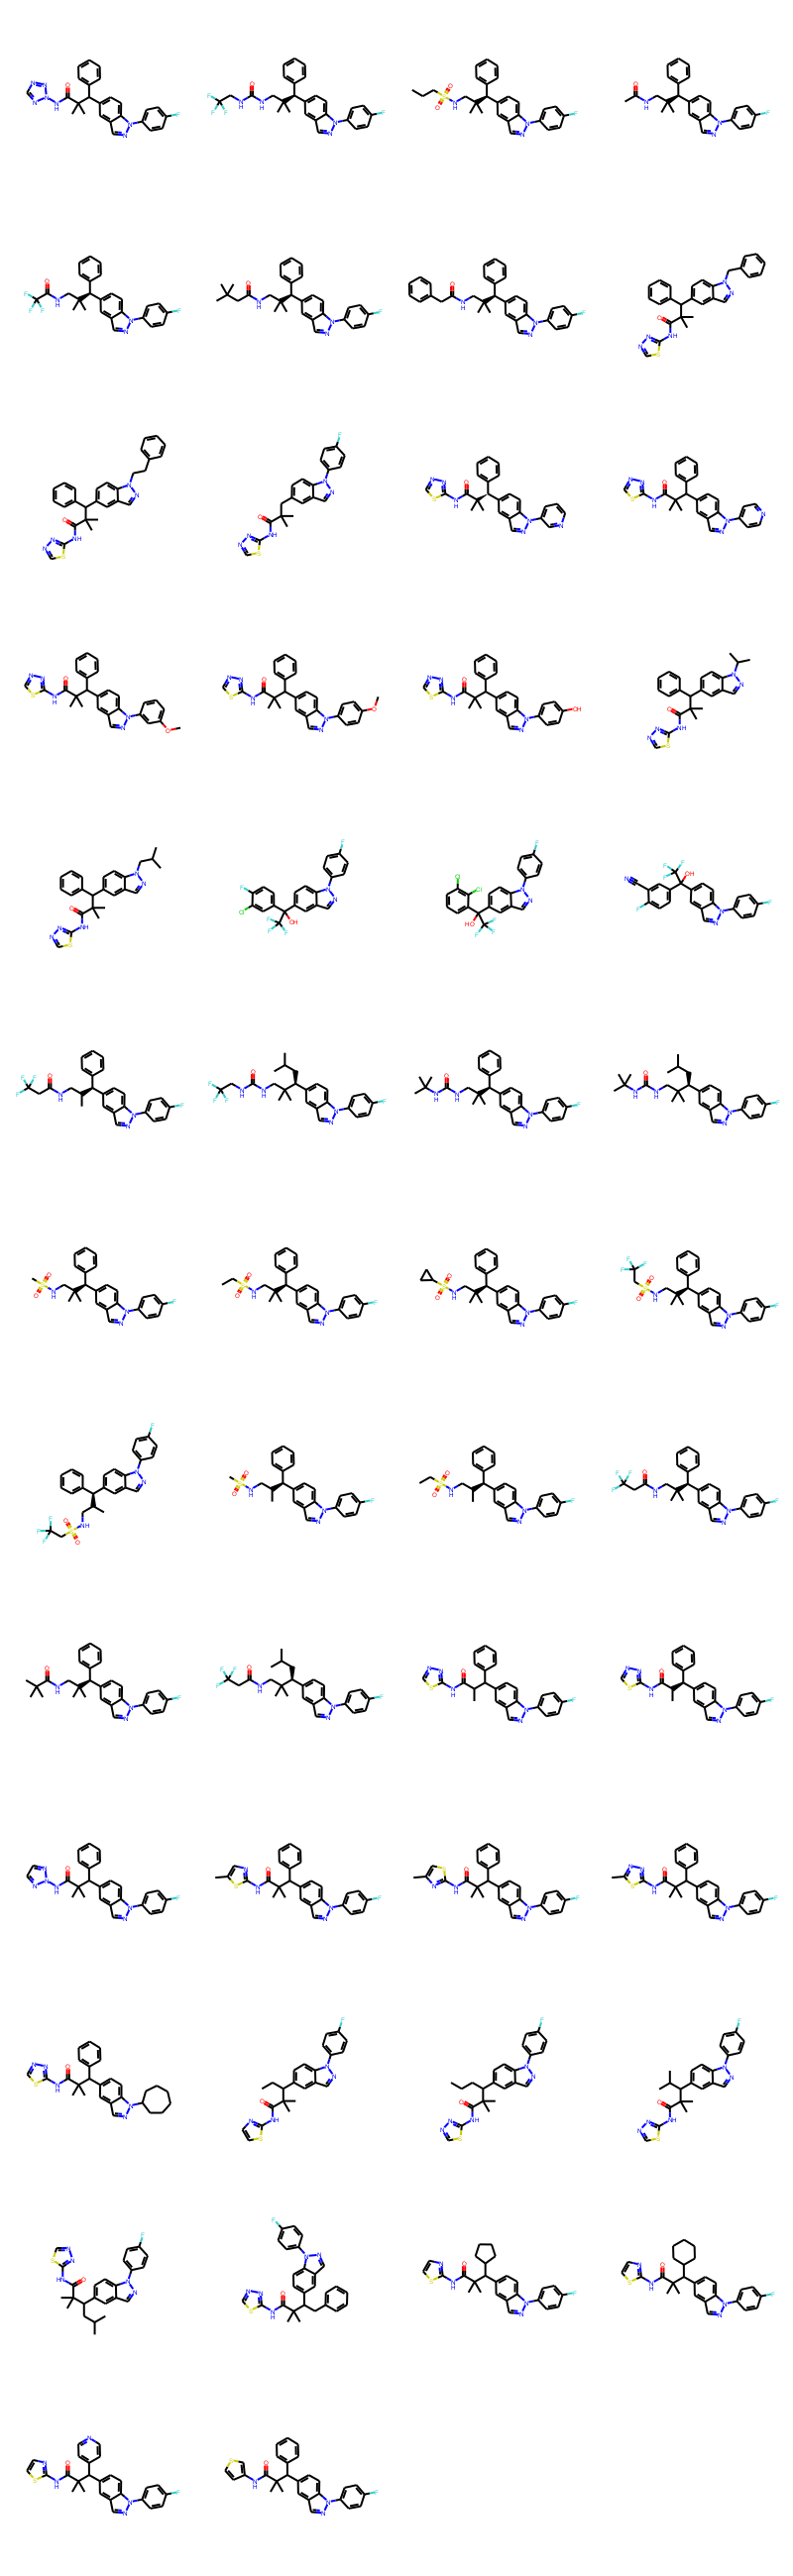

In [184]:
Draw.MolsToGridImage([ms[x] for x in clusters[cluster40[1]]],molsPerRow=4)

In [185]:
len(clusters[cluster40[1]])

63

In [190]:
[y[x] for x in clusters[cluster40[1]]]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

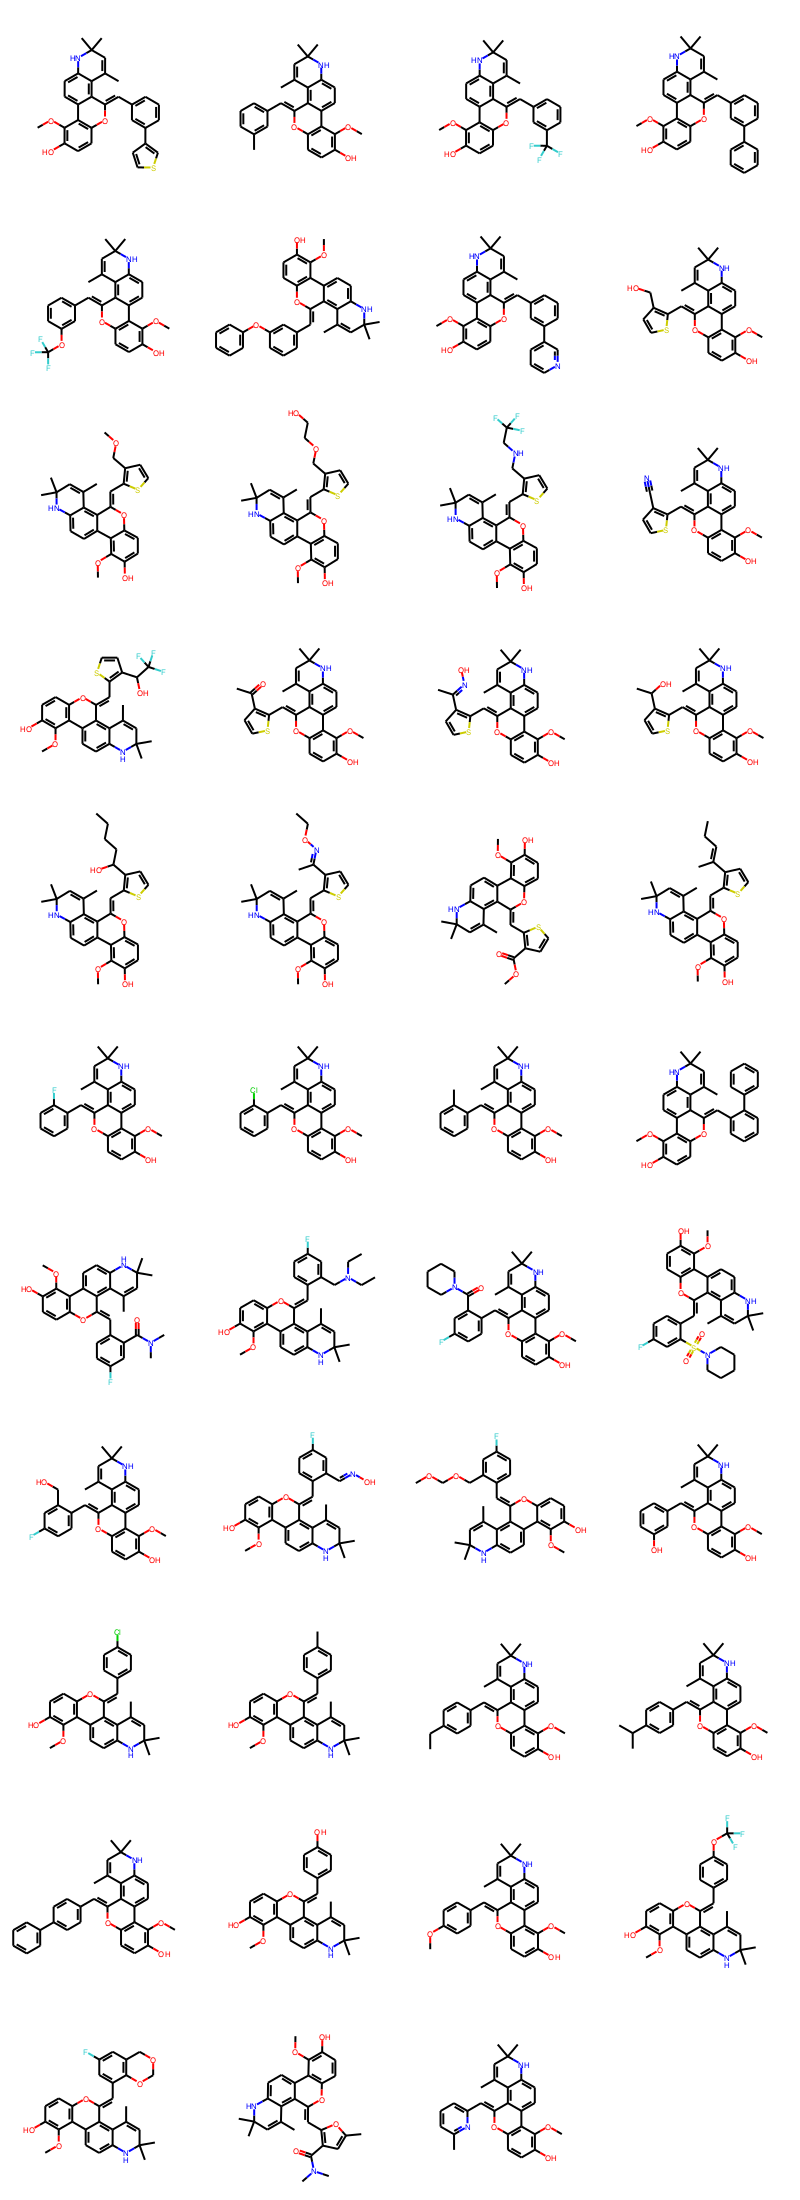

In [188]:
Draw.MolsToGridImage([ms[x] for x in clusters[cluster40[2]]],molsPerRow=4)

In [186]:
len(clusters[cluster40[2]])

43

In [191]:
[y[x] for x in clusters[cluster40[2]]]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]